<a href="https://colab.research.google.com/github/harikuttan7136/ELL888-Minor-Graph-learning/blob/main/Graph_learning_missing_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=sys.maxsize)
import random


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_banknote_authentication.txt to data_banknote_authentication.txt


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data_banknote_authentication.txt']),header=None)
#df = pd.read_csv(io.BytesIO(uploaded['HTRU_2.csv']),header=None)
df=df.drop_duplicates()

In [ ]:
df.count()

0    1348
1    1348
2    1348
3    1348
4    1348
dtype: int64

In [ ]:
# a function which creates missing values and returns mask of missing values 
def createMissingData(X):
  X_new=[]
  mask=[]
  N=X.shape[1]
  temp_X=X.copy()
  for i in temp_X:
    t=random.randint(0,2)
    if t==1 or t==0 :
      X_new.append(i)
      mask.append(np.ones(N))
      continue
    no_mis=random.randint(0,N/2)
    index_mis=random.sample(range(0,N), no_mis)
    mask_i=np.ones(N)
    for j in index_mis:
      mask_i[j]=0
      i[j]=np.nan
    X_new.append(i)
    mask.append(mask_i)
  return [np.array(X_new),np.array(mask)]

In [ ]:
X, X_test, Y, y_test = train_test_split(df.drop(4,axis=1).to_numpy(), df[4].to_numpy(), test_size=0.98, random_state=42)

In [ ]:
X,mask=createMissingData(X)

In [ ]:
def findPartialMeanCovariance(X):
  N=X.shape[1]
  mean=np.nanmean(X,axis=0)
  """X_mis=X[:,np.where(mask_i==0)[0]]
  X_present=X[:,np.where(mask_i==1)[0]]
  X_mis = X_mis[~np.isnan(X_mis).any(axis=1)]"""
  X_present = X[~np.isnan(X).any(axis=1)]
  cov=np.cov(X_present.T)
  return mean,cov
  

In [ ]:
# sample mean and covariance matrix for the complete data
mean,cov=findPartialMeanCovariance(X)

In [ ]:
# return new xi with no missing values(substituted with conditional mean)  and (si)^2
def get_newX(x,mask,mean,cov):
  n=cov.shape[0]
  mean_miss=mean[np.where(mask==0)[0]]
  x_pres=x[np.where(mask==1)[0]]
  mean_pres=mean[np.where(mask==1)[0]]
  mis_shape=len(mean_miss)
  pres_shape=n-mis_shape
  E11=[]
  E22=[]
  E12=[]
  E21=[]
  for i in range(n):
    for j in range(n):
      if mask[i]==0 and mask[j]==0:
        E11.append(cov[i][j])
      elif mask[i]==0 and mask[j]==1:
        E12.append(cov[i][j])
      elif mask[i]==1 and mask[j]==0:
        E21.append(cov[i][j])
      else:
        E22.append(cov[i][j])
  E11=np.array(E11).reshape((mis_shape,mis_shape))
  E12=np.array(E12).reshape((mis_shape,pres_shape))
  E21=np.array(E21).reshape((pres_shape,mis_shape))
  E22=np.array(E22).reshape((pres_shape,pres_shape))
  try:
    E22_inv=np.linalg.inv(E22)
    mean_=mean_miss + np.dot(np.dot(E12,E22_inv),(x_pres-mean_pres))
    E11_=E11-np.dot(E12,np.dot(E22_inv,E21))
    trace=np.sum(np.trace(E11_))
  except:
    mean_=mean_miss  
    trace=0
  k=0
  temp_x=x.copy()
  for i in range(n):
    if mask[i]==0:
      temp_x[i]=mean_[k]
      k+=1
  return temp_x,trace

In [ ]:
# finding the pairwise distance note that s_i=0 if no value is missing in the sample
def findDistancematrix(X,mask):
  mean,cov=findPartialMeanCovariance(X)
  n=X.shape[0]
  d=X.shape[1]
  D=np.zeros((n,n))
  for i in range(n):
    if np.sum(mask[i]<d):
      x_i,s_i =get_newX(X[i],mask[i],mean,cov)
    else:
      x_i=X[i]
      s_i=0
    for j in range(i+1,n):
      if np.sum(mask[j]<d):
        x_j,s_j =get_newX(X[j],mask[j],mean,cov)
      else:
        x_j=X[j]
        s_j=0
      dist=np.linalg.norm(x_i-x_j)
      D[i][j]=dist+s_i+s_j
      D[j][i]=dist+s_i+s_j
  return D 

In [ ]:
# getting the edges with kNN graph 
def kNN_graph(D,k=5):
  n=D.shape[0]
  E=np.zeros((n,n))
  for i in range(n):
    dist=D[i]
    idx = np.argpartition(dist, k)
    count=0
    for j in idx:
      if i!=j and i in np.argpartition(D[j], k):
        E[i][j]=1
        count+=1
      if count==k:
        break
  return E

In [ ]:
D=findDistancematrix(X,mask)
E=kNN_graph(D)

In [ ]:
#graph with just mean imputation
dfX=pd.DataFrame(X)
dfX=dfX.fillna(dfX.mean())
Ddf=euclidean_distances(dfX,dfX)
Edf=kNN_graph(Ddf)

In [ ]:
X.shape

(26, 4)

In [ ]:
# changing Y values for missing values for plotting
Y_tot=Y.copy()
for i in range(len(Y)):
  if np.sum(mask[i])<X.shape[1]:
    Y_tot[i]=2 if Y[i]==1 else -1

In [ ]:
Y_tot

array([-1, -1,  0,  2,  0,  1,  2, -1,  1,  0,  1,  2,  0,  1,  1,  0,  0,
        1,  0,  0,  1,  1,  1,  1,  1,  2])

In [ ]:
Y

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1])

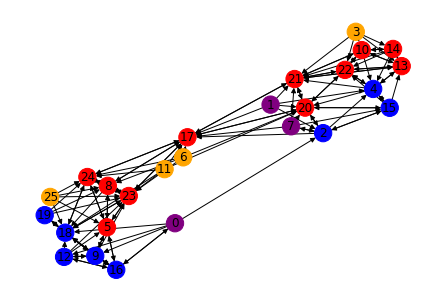

In [ ]:
# graph with proposed algorithm
import networkx as nx 
import matplotlib.pyplot as plt
G = nx.DiGraph()
color_map=[]
for i in range(len(Y_tot)):
  G.add_node(i)
  if Y_tot[i]==-1:
    color_map.append("purple")
  elif Y_tot[i]==0:
    color_map.append("blue")
  elif Y_tot[i]==2:
    color_map.append("orange")
  else:
    color_map.append("red")
for i in range(E.shape[0]): 
 for j in range(E.shape[1]): 
   if E[i][j] == 1: 
      G.add_edge(i,j) 
nx.draw( G ,node_color=color_map,with_labels=True) 
plt.show() 


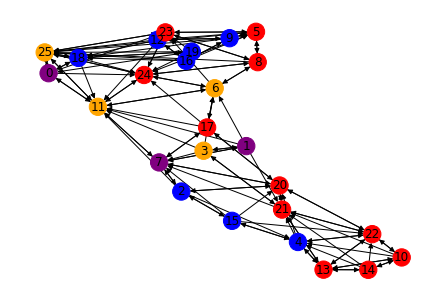

In [ ]:
# graph with just mean imputation
import networkx as nx 
import matplotlib.pyplot as plt
G = nx.DiGraph()
color_map=[]
for i in range(len(Y_tot)):
  G.add_node(i)
  if Y_tot[i]==-1:
    color_map.append("purple")
  elif Y_tot[i]==0:
    color_map.append("blue")
  elif Y_tot[i]==2:
    color_map.append("orange")
  else:
    color_map.append("red")
for i in range(Edf.shape[0]): 
 for j in range(Edf.shape[1]): 
   if Edf[i][j] == 1: 
      G.add_edge(i,j) 
nx.draw( G ,node_color=color_map,with_labels=True) 
plt.show() 
